### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, coalesce
import networkx as nx
from typing import Literal
import torch.nn.functional as fn

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)


<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [5]:
batch_size = 1
sampled_graphs = 20

learning_rate_mlp = 0.003        #0.003 on ADAM
coefficientSizeReg = 0.05
entropyReg = 1
epochs_mlp = 30

# Temperature
t_0 =  5.0
t_T = 2.0

datasetName: Literal['BA2Motif','MUTAG'] = 'BA2Motif'

### Load and visualize data

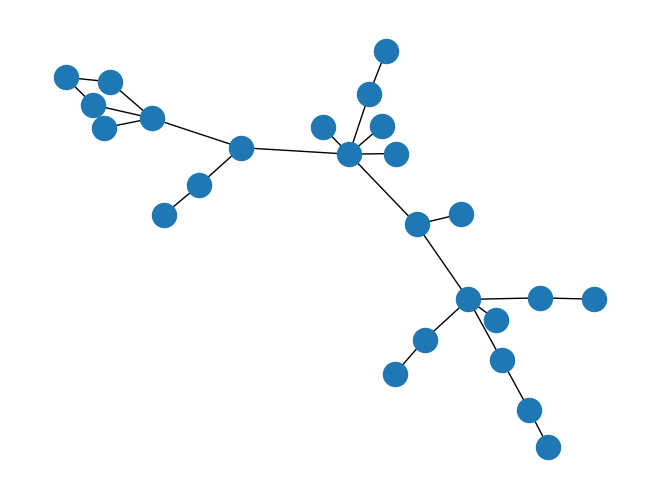

In [6]:
train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

# TODO: Color different classes? Problem: BA2Motif Graph datasets have no node labels?!
g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g)

train_loader = DataLoader(train_dataset, batch_size, False)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! To improve: Add hidden embeddings to data objects????
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

In [11]:
for data in train_dataset:
    print(data)
    print(data.edge_index)

    loopsRem, _ = remove_self_loops(data.edge_index)
    print(loopsRem)

    coal, _ = coalesce(data.edge_index, None, data.num_nodes)
    print(coal)
    break

Data(x=[25, 10], edge_index=[2, 52], y=[1])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  4,  8,  9, 11, 20,  0, 12, 15,  0,  3,  2, 10,  0,  5,  7, 16,
         17,  4,  6, 13, 18,  5,  4,  0,  0,  3,  0,  1, 14,  5, 19, 12,  1,  4,
          4,  5, 13,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  4,  8,  9, 11, 20,  0, 12, 15,  0,  3,  2, 10,  0,  5,  7, 16,
         17,  4,  6, 13, 18,  5,  4,  0,  0,  3,  0,  1, 14,  5, 19, 12,  1,  4,
          4,  5, 13,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 

### Load GNN model

In [7]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/BA2Motif 100", weights_only=True))

<All keys matched successfully>

In [3]:
def weights_init(module):
    # This only initializes weight for lin layer
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        #if module.bias is not None:            # Xavier not usable for bias?

### Training Loop Graph Classification Explainer

In [ ]:
mlp = networks.MLP(features= 40)
mlp.apply(weights_init)             # TODO: Validate

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp)

modelGraphGNN.eval()
for param in modelGraphGNN.parameters():
    param.requires_grad = False

embeddings = mlp.getGraphEdgeEmbeddings(train_loader, modelGraphGNN)

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    Loss = torch.FloatTensor([0])

    for batch_index, data in enumerate(train_loader):
        # MLP forward                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        out = mlp.forward(embeddings[batch_index])              # shape: ~50 X 1 = Edges X MLP_out(edge_weight)
        w_ij = out.squeeze(1)                                   # shape: ~50 X 1 = EdgesOG X MLP_out(edge_weight)

        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            sizeReg = torch.sum(edge_ij) * coefficientSizeReg
            print(sizeReg)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here
            pOriginal = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch), dim=1)
            pSample = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch
            for graph_index in range(data.num_graphs):
                currLoss = mlp.loss(pOriginal[graph_index], pSample[graph_index], edge_ij, coefficientSizeReg, entropyReg)
                #lossEntropy = fn.cross_entropy(fn.softmax(pOriginal,dim=1), fn.softmax(pSample, dim=1))
                Loss += currLoss
    
    Loss = Loss / len(train_loader) / sampled_graphs / batch_size           # TODO: Validate, apply batchsizeratio 

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    Loss.backward()
    mlp_optimizer.step()

Epoch 1, Loss: 1.876190185546875
Epoch 2, Loss: 1.8559401035308838
Epoch 3, Loss: 1.835059404373169
Epoch 4, Loss: 1.817631483078003
Epoch 5, Loss: 1.7909778356552124
Epoch 6, Loss: 1.7727296352386475
Epoch 7, Loss: 1.747820496559143


KeyboardInterrupt: 

In [53]:
torch.save(mlp.state_dict(), f"models/explainerBA2Motif Regularized")

In [13]:
mlp = networks.MLP(features = 40)     # Adjust according to data and task
mlp.load_state_dict(torch.load("models/explainerBA2Motif Regularized BAD", weights_only=True))

<All keys matched successfully>

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,  True])
tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,
          4,  4,  5,  6,  6,  7,  7,  8,  9, 10, 10, 11, 12, 13, 14, 15, 15, 16,
         17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  8,  9, 12, 20,  0,  3,  7, 11, 18,  0,  4,  5, 10, 16, 19,  1,
          2,  6,  2,  4, 15,  1, 13,  0,  0,  2, 14,  1,  0,  7, 10,  6, 17,  2,
         15,  1,  2,  0, 21, 24, 20, 22, 21, 23, 22, 24, 20, 23]])
tensor([[ 1,  2,  2, 21, 24],
        [ 7,  4, 10, 22, 23]])
-----------------Original Graph-----------------
-----------------Sampled Graph------------

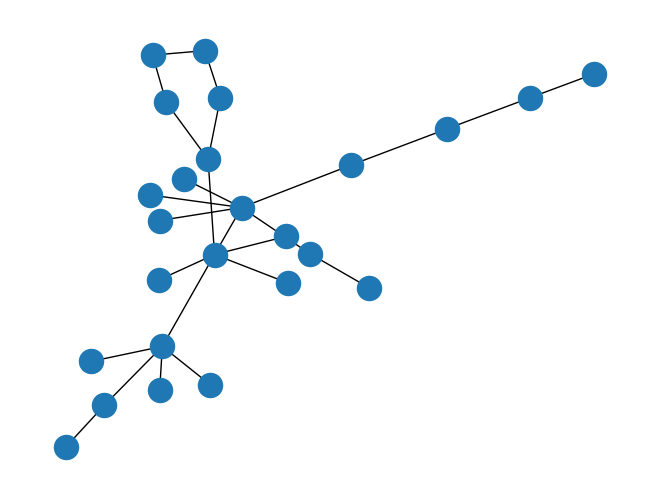

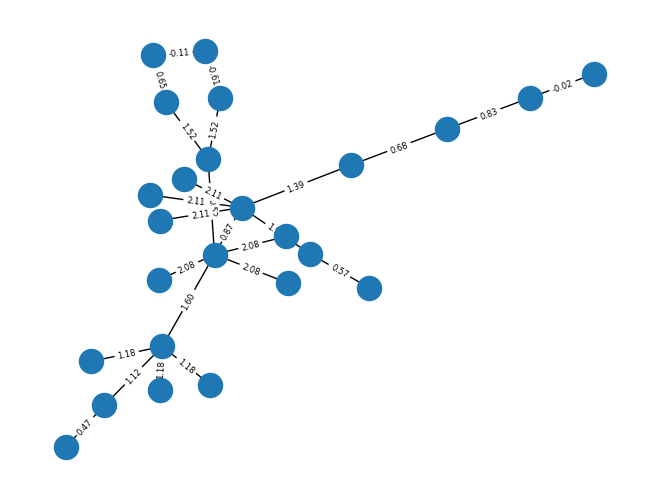

In [12]:
mlp.eval()
data1 = train_dataset[2]

printLoader = DataLoader([data1], 1, False)

embeddings = mlp.getGraphEdgeEmbeddings(printLoader, modelGraphGNN)

temperature = t_0*((t_T/t_0) ** (1))

out = mlp.forward(embeddings[0])

w_ij = out.squeeze(1)
edge_ij = mlp.sampleGraph(w_ij, temperature)


# This is useless. Instead: Take the 5 highest edge weights and draw these
##k_mask = edge_ij > 0.5                                      # shape: ~50 X 1 = EdgesOG X SampledEdgesMask
##edge_index_masked = data1.edge_index[:,k_mask]

_, top_k_indices = torch.topk(w_ij, k=5, largest=False)

mask = torch.zeros_like(w_ij, dtype=torch.bool)
mask[top_k_indices] = True

print(mask)
print(data1.edge_index)

edge_index_masked = data1.edge_index[:,mask]

print(edge_index_masked)

Gs = Data(x=data1.x, edge_index=data1.edge_index, edge_attr=w_ij)

print("-----------------Original Graph-----------------")
gO = torch_geometric.utils.to_networkx(data1, to_undirected=True)
pos = nx.spring_layout(gO)
plt.figure(2)
nx.draw(gO, pos=pos)

print("-----------------Sampled Graph-----------------")
gS = torch_geometric.utils.to_networkx(Gs, edge_attrs=["edge_attr"], to_undirected=True)
plt.figure(1)
nx.draw(gS, pos=pos)

labels = nx.get_edge_attributes(gS,'edge_attr')
labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(gS, 'edge_attr').items()}
nx.draw_networkx_edge_labels(gS, pos, edge_labels=labels, font_size=6)
#print(modelGraphGNN.forward(Gs.x, Gs.edge_index))

plt.show()

In [22]:
embeddings = []

modelGraphGNN.eval()

for batch_index, data in enumerate(train_loader):
    emb = modelGraphGNN.getNodeEmbeddings(data.x, data.edge_index)

    print(data.edge_index)

    graph_embs = []
    for index in range(0, len(data.edge_index[0])):
        i = data.edge_index[0][index]
        j = data.edge_index[1][index]

        embCat = torch.cat([emb[i],emb[j]])

        graph_embs.append(embCat)

    embeddings.append(torch.stack(graph_embs))
    #embeddings.append(graph_embs)

embeddings_tensor = torch.cat(embeddings, dim=0)

print(embeddings_tensor[0])

tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  3,  4,  5,  6,
          7,  7,  8,  9,  9,  9, 10, 11, 11, 12, 12, 13, 14, 14, 14, 15, 16, 17,
         18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  4,  5,  6, 11,  0,  2,  3,  8,  9, 10, 17,  1,  7,  1,  0,  0,  0,
          2, 14,  1,  1, 13, 16,  1,  0, 12, 11, 19,  9,  7, 15, 18, 14,  9,  1,
         14, 12, 20, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  3,  3,  4,  4,  4,  4,  5,  6,
          7,  7,  7,  8,  8,  9, 10, 10, 10, 10, 10, 11, 12, 13, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  3,  4,  5, 12, 20,  0,  6,  0,  0,  8,  0,  7,  9, 15,  0,  1,
          4, 10, 19,  3, 16,  4,  7, 11, 13, 14, 18, 10,  0, 10, 17, 10,  4,  8,
         13, 10,  7,  0, 21, 24, 20, 22, 21, 23, 22, 24, 20, 23]])
tensor([[ 0,  0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  

KeyboardInterrupt: 